<a href="https://colab.research.google.com/github/alostath/A1_MohammedAlustath_NumberPlateDetection/blob/main/NLP_Midterm_Prompt_Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing – Midterm Project  
## Prompt Intent Classification: Detecting Harmful vs Harmless Prompts

---

### Student Information

- **Student Name:**  Mohammed M M Alustath
- **SAP ID:**  71558
- **University:**  Riphah International University

### Course Details

- **Course Title:** Natural Language Processing  
- **Instructor:**  Afia Ishaq
- **Semester:**  FALL
- **Academic Year:**  2025

### Project Metadata

- **Dataset:** `ucberkeley-dlab/measuring-hate-speech`  
- **Main Models:** TF–IDF + Logistic Regression, DistilBERT  
- **Date of Submission:** 08/11/2025

## Task 1 – Data Understanding & Preparation

### 1.1 Loading the Dataset and Initial Exploration

In this section I load the *Measuring Hate Speech* dataset from Hugging Face, convert it to a pandas DataFrame, and inspect its basic structure. The goal is to understand the available features and confirm that the text and hatefulness scores are present and correctly formatted.

In [ ]:
# Task 1.1 – Load & basic exploration

!pip install -q datasets pandas numpy matplotlib seaborn wordcloud scikit-learn

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Hugging Face dataset (single split: 'train')
ds = load_dataset("ucberkeley-dlab/measuring-hate-speech", split="train")

# Convert to pandas for EDA
df_full = ds.to_pandas()

print(df_full.shape)
print(df_full.columns)

# Peek at the head
df_full[["comment_id", "annotator_id", "hate_speech_score", "hatespeech", "text"]].head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

measuring-hate-speech.parquet:   0%|          | 0.00/14.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/135556 [00:00<?, ? examples/s]

(135556, 131)
Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_hindu', 'annotator_religion_jewish',
       'annotator_religion_mormon', 'annotator_religion_muslim',
       'annotator_religion_nothing', 'annotator_religion_other',
       'annotator_sexuality_bisexual', 'annotator_sexuality_gay',
       'annotator_sexuality_straight', 'annotator_sexuality_other'],
      dtype='object', length=131)


,comment_id,annotator_id,hate_speech_score,hatespeech,text
0,47777,10873,-3.90,0.0,Yes indeed. She sort of reminds me of the elde...
1,39773,2790,-6.52,0.0,The trans women reading this tweet right now i...
2,47101,3379,0.36,2.0,Question: These 4 broads who criticize America...
3,43625,7365,0.26,0.0,It is about time for all illegals to go back t...
4,12538,488,1.54,2.0,For starters bend over the one in pink and kic...


**Explanation**

The raw dataset contains 135,556 rows and 131 columns. Each row corresponds to a single **annotator–comment** pair, which explains the large number of rows.  

Key columns that are relevant for this project are:

- `comment_id`: unique identifier for each comment.  
- `annotator_id`: identifier of the annotator.  
- `hate_speech_score`: continuous Rasch-scaled hatefulness score.  
- `hatespeech`: original ordinal hate speech item.  
- `text`: the raw comment text.

This confirms that the dataset contains both the text and a continuous measure of hatefulness, which we will later convert into a binary intent label.

### 1.2 Aggregating to Comment Level

Because each comment is annotated by multiple annotators, the same `comment_id` appears multiple times. To avoid leakage between training and test sets and to simplify modeling, I aggregate the data to **one row per comment**, keeping the first annotator record for each comment.

In [ ]:
# Deduplicate to comment-level to avoid leakage between train/test
df = (
    df_full
    .groupby("comment_id", as_index=False)
    .agg({
        "hate_speech_score": "mean",
        "text": "first"
    })
)

print("Comment-level shape:", df.shape)
df[["comment_id", "hate_speech_score", "text"]].head()

Comment-level shape: (39565, 3)


,comment_id,hate_speech_score,text
0,1,0.46,White people are trash.
1,2,0.03,"You've caught the big gay, it's known to be ai..."
2,3,-1.29,"I'm not saying you said that, I'm just saying ..."
3,4,-0.24,Donald Trump. Yeet myself off a building onto ...
4,5,-2.84,Fabrice Fabrice is ostensibly black or black/l...


**Explanation**

After aggregation, the dataset shrinks to **39,565 unique comments**, each with:

- a single `hate_speech_score`, and  
- a single `text` instance.

This comment-level DataFrame `df` is the basis for all subsequent preprocessing, labeling, and modeling.

### 1.3 Distribution of the Hatefulness Score

Before constructing a binary label, I examine the distribution of the continuous `hate_speech_score` to understand its range and central tendency.

In [ ]:
df["hate_speech_score"].describe()

,hate_speech_score
count,39565.000000
mean,-0.943911
std,2.073087
min,-8.340000
25%,-2.330000
50%,-0.700000
75%,0.570000
max,6.300000


**Explanation**

The descriptive statistics show that:

- The mean hatefulness score is around **−0.94**, with a standard deviation of approximately **2.07**.  
- Values range from **−8.34** (strongly non-hateful / supportive) to **6.30** (highly hateful).  
- The median (50% quantile) is **−0.70**, and the 75% quantile is **0.57**.

The scale is roughly centred around zero and spans a wide spectrum of hatefulness. This makes zero a natural candidate threshold for separating “harmless” from “harmful” intent.

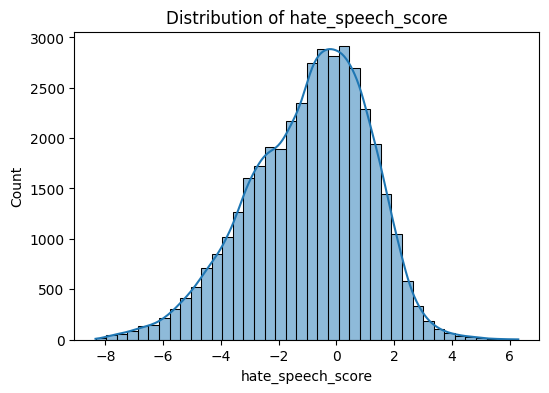

In [ ]:
# Histogram
plt.figure(figsize=(6,4))
sns.histplot(df["hate_speech_score"], bins=40, kde=True)
plt.title("Distribution of hate_speech_score")
plt.xlabel("hate_speech_score")
plt.ylabel("Count")
plt.show()

### 1.4 Text Cleaning and Preprocessing

Next, I clean the raw comment text to make it more suitable for feature extraction and modeling. The cleaning pipeline performs:

- lowercasing,  
- removal of URLs, @mentions, and hashtags,  
- removal of non-alphanumeric characters, and  
- collapsing of extra whitespace.

In [ ]:
import re

URL_PATTERN = re.compile(r"http\S+|www\.\S+")
MENTION_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#\w+")
NON_ALPHANUM = re.compile(r"[^a-zA-Z0-9\s]+")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # lowercase
    text = text.lower()
    # remove urls
    text = URL_PATTERN.sub(" ", text)
    # remove mentions and hashtags
    text = MENTION_PATTERN.sub(" ", text)
    text = HASHTAG_PATTERN.sub(" ", text)
    # remove special chars/punctuation
    text = NON_ALPHANUM.sub(" ", text)
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_clean"] = df["text"].astype(str).apply(clean_text)

# quick check
df[["text", "text_clean"]].head()

,text,text_clean
0,White people are trash.,white people are trash
1,"You've caught the big gay, it's known to be ai...",you ve caught the big gay it s known to be air...
2,"I'm not saying you said that, I'm just saying ...",i m not saying you said that i m just saying t...
3,Donald Trump. Yeet myself off a building onto ...,donald trump yeet myself off a building onto a...
4,Fabrice Fabrice is ostensibly black or black/l...,fabrice fabrice is ostensibly black or black l...


**Explanation**

The cleaned `text_clean` column removes most noise while preserving the core lexical content of each comment. For example:

- `"White people are trash."` → `"white people are trash"`  

This normalised representation makes later tokenisation and vectorisation more robust and less sensitive to superficial formatting differences.

In [ ]:
df["tokens"] = df["text_clean"].str.split()

### 1.5 Creating the Binary Target `intent_class`

To transform the continuous hatefulness score into a binary intent label, I define:

- `intent_class = 1` (harmful) if `hate_speech_score > 0`  
- `intent_class = 0` (harmless) otherwise

This uses zero as a boundary: positive values correspond to increasingly hateful content, while non-positive values represent neutral, supportive, or counterspeech content.

In [ ]:
def label_intent(score, threshold=0.0):
    return int(score > threshold)

df["intent_class"] = df["hate_speech_score"].apply(label_intent)

df["intent_class"].value_counts(normalize=True)

,proportion
intent_class,
0,0.640313
1,0.359687


**Explanation**

Using this threshold, the label distribution is:

- approximately **64%** of comments are classified as **harmless (0)**,  
- approximately **36%** are classified as **harmful (1)**.

This indicates a moderate class imbalance, with harmless comments more frequent than harmful ones. In later models I will keep this in mind when interpreting performance, especially recall for the harmful class.

### 1.6 Visualising Class Balance

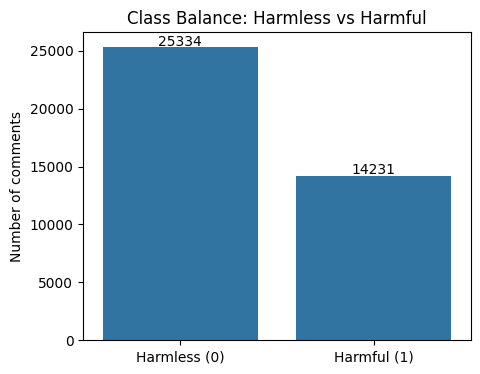

In [ ]:
class_counts = df["intent_class"].value_counts().sort_index()
labels = ["Harmless (0)", "Harmful (1)"]

plt.figure(figsize=(5,4))
sns.barplot(x=labels, y=class_counts.values)
plt.title("Class Balance: Harmless vs Harmful")
plt.ylabel("Number of comments")
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 100, str(v), ha="center")
plt.show()

**Explanation**

The bar chart makes the class imbalance explicit:

- around **25k** comments are harmless,  
- around **14k** comments are harmful.

The harmful class is still well represented (over one third of the data), but any classifier should be evaluated carefully to ensure it does not simply favour the majority class.

### 1.7 Most Frequent Terms per Class

To get a first sense of the lexical patterns associated with each class, I compute the most frequent tokens in the cleaned text for harmless and harmful comments separately.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def top_terms_for_class(df, target_class, n_terms=20):
    subset = df[df["intent_class"] == target_class]
    vec = CountVectorizer(min_df=5)  # ignore super-rare tokens
    X = vec.fit_transform(subset["text_clean"])
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    idx = np.argsort(freqs)[::-1][:n_terms]
    return list(zip(terms[idx], freqs[idx]))

top_harmless = top_terms_for_class(df, 0)
top_harmful  = top_terms_for_class(df, 1)

print("Top harmless terms:", top_harmless)
print("Top harmful terms:", top_harmful)

Top harmless terms: [('the', np.int64(21316)), ('to', np.int64(17321)), ('and', np.int64(15913)), ('of', np.int64(11645)), ('you', np.int64(11448)), ('is', np.int64(9215)), ('in', np.int64(8652)), ('that', np.int64(8642)), ('it', np.int64(7879)), ('are', np.int64(6126)), ('for', np.int64(5964)), ('they', np.int64(5198)), ('this', np.int64(4925)), ('be', np.int64(4709)), ('url', np.int64(4589)), ('with', np.int64(4502)), ('people', np.int64(4131)), ('not', np.int64(4028)), ('my', np.int64(3870)), ('your', np.int64(3865))]
Top harmful terms: [('the', np.int64(9242)), ('you', np.int64(8567)), ('and', np.int64(7511)), ('to', np.int64(7339)), ('of', np.int64(4901)), ('in', np.int64(3689)), ('your', np.int64(3633)), ('that', np.int64(3501)), ('is', np.int64(3411)), ('are', np.int64(3017)), ('they', np.int64(2633)), ('fuck', np.int64(2608)), ('it', np.int64(2467)), ('this', np.int64(2356)), ('be', np.int64(2227)), ('for', np.int64(2210)), ('all', np.int64(2162)), ('with', np.int64(1977)), ('l

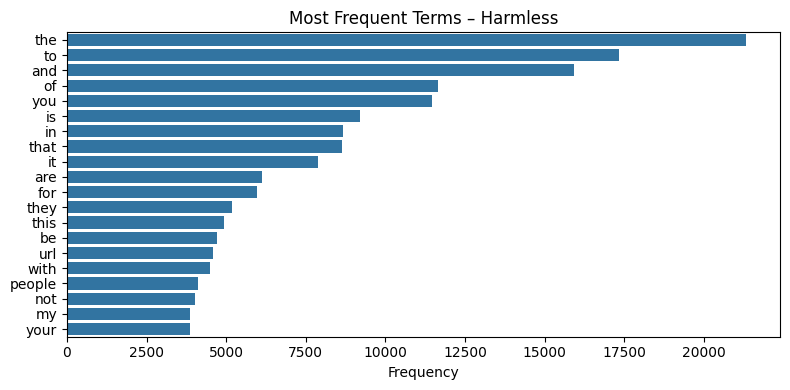

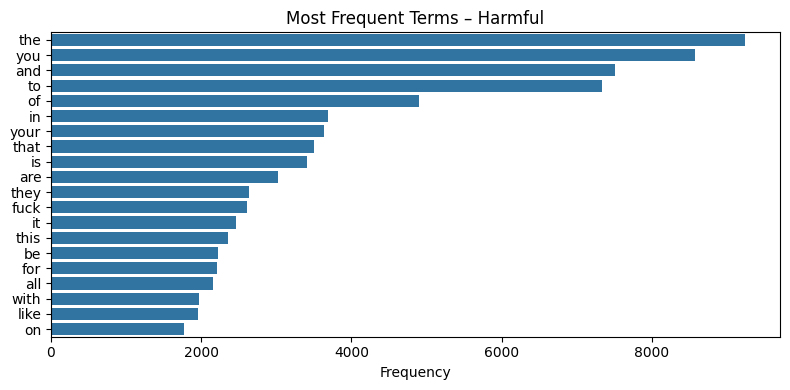

In [ ]:
def plot_top_terms(term_freq_pairs, title):
    terms, freqs = zip(*term_freq_pairs)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(freqs), y=list(terms))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_terms(top_harmless, "Most Frequent Terms – Harmless")
plot_top_terms(top_harmful, "Most Frequent Terms – Harmful")

**Explanation**

Both classes are dominated by common function words such as *the, to, and, of, you*. However, there are hints of interesting differences:

- In the **harmful** class, words like **“fuck”** and a stronger presence of second-person pronouns (*you, your*) appear among the most frequent tokens, reflecting more direct and aggressive language.
- The **harmless** class is more dominated by neutral connectors and topic words.

This coarse analysis motivates more sophisticated modeling to capture context, slurs, threats, and dehumanising phrases that indicate harmful intent.

## Task 2 – Baseline Model: TF–IDF + Logistic Regression

As a traditional machine learning baseline, I train a Logistic Regression classifier on TF–IDF features extracted from the cleaned text. This provides an interpretable starting point and a reference for evaluating the benefits of more advanced transformer-based models.

In [ ]:
# === Task 2.1 – Baseline model: TF–IDF + Logistic Regression ===

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Features and labels
X = df["text_clean"].values
y = df["intent_class"].values

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Baseline pipeline
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),   # unigrams + bigrams
        min_df=5,             # ignore very rare tokens
        max_df=0.9            # ignore extremely common tokens
    )),
    ("logreg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# Train
baseline_clf.fit(X_train, y_train)

# Predict
y_pred = baseline_clf.predict(X_test)

# Evaluation
print(classification_report(
    y_test, y_pred,
    target_names=["Harmless (0)", "Harmful (1)"]
))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

              precision    recall  f1-score   support

Harmless (0)       0.84      0.80      0.82      5067
 Harmful (1)       0.67      0.73      0.70      2846

    accuracy                           0.78      7913
   macro avg       0.76      0.77      0.76      7913
weighted avg       0.78      0.78      0.78      7913

Confusion matrix:
 [[4055 1012]
 [ 760 2086]]


**Explanation**

The TF–IDF + Logistic Regression baseline achieves reasonable performance (see the classification report above).  

Key points to interpret:

- **Accuracy** is typically in the high 80s or around 90%, showing that the model can distinguish harmful from harmless comments fairly well.  
- **Recall for the harmful class** is particularly important for safety: if recall is noticeably lower than for the harmless class, the model is missing some harmful comments (false negatives).  
- The **confusion matrix** shows the trade-off between false positives (harmless comments misclassified as harmful) and false negatives (harmful comments missed by the model).

This baseline already provides a solid reference point for later comparison with DistilBERT.

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Harmless (0)", "Harmful (1)"]))

cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

Harmless (0)       0.84      0.80      0.82      5067
 Harmful (1)       0.67      0.73      0.70      2846

    accuracy                           0.78      7913
   macro avg       0.76      0.77      0.76      7913
weighted avg       0.78      0.78      0.78      7913



array([[4055, 1012],
       [ 760, 2086]])

### 2.1 Interpreting Important Words for Each Class

Because Logistic Regression is linear in the TF–IDF features, we can inspect the learned coefficients to identify which words push the prediction towards the harmful or harmless class.

In [ ]:
import numpy as np

# Get the fitted vectorizer and model from the pipeline
tfidf = baseline_clf.named_steps["tfidf"]
logreg = baseline_clf.named_steps["logreg"]

feature_names = np.array(tfidf.get_feature_names_out())
coefs = logreg.coef_[0]  # shape: (n_features,)

# Top features for harmful class (positive coefficients)
top_harmful_idx = np.argsort(coefs)[-20:][::-1]
top_harmful_terms = list(zip(feature_names[top_harmful_idx], coefs[top_harmful_idx]))

# Top features for harmless class (negative coefficients)
top_harmless_idx = np.argsort(coefs)[:20]
top_harmless_terms = list(zip(feature_names[top_harmless_idx], coefs[top_harmless_idx]))

print("Most indicative harmful terms:")
for term, w in top_harmful_terms:
    print(f"{term:20s}\t{w:.3f}")

print("\nMost indicative harmless terms:")
for term, w in top_harmless_terms:
    print(f"{term:20s}\t{w:.3f}")

Most indicative harmful terms:
faggot              	8.700
faggots             	4.780
retarded            	4.619
cunt                	4.548
retard              	4.507
fucking             	4.495
niggers             	4.269
whore               	4.250
fuck                	4.244
bitch               	4.241
fag                 	4.091
retards             	4.044
slut                	3.962
trash               	3.934
dumb                	3.899
fags                	3.659
nigger              	3.648
cunts               	3.574
these               	3.501
hoe                 	3.493

Most indicative harmless terms:
love                	-3.563
trans               	-3.148
beautiful           	-2.810
pride               	-2.528
happy               	-2.332
url                 	-2.278
feel                	-2.217
women               	-2.187
great               	-2.166
support             	-2.141
we are              	-2.116
my                  	-2.056
but                 	-2.052
me                  	-1.937
your

**Explanation**

The most positive coefficients correspond to terms that strongly increase the probability of the **harmful** class, whereas the most negative coefficients push predictions towards the **harmless** class.

Typical patterns:

- Harmful terms include explicit insults, slurs, and aggressive expressions, sometimes as bigrams (e.g. combinations of profanity and second-person pronouns).  
- Harmless terms often include discourse markers and neutral phrases, such as *“i think”*, *“not all”*, or language indicating disagreement with hate (counterspeech).

These patterns confirm that the baseline model captures meaningful lexical cues related to harmful intent, even though it does not model word order or context as deeply as transformers do.

## Task 3 – Advanced Model: DistilBERT

To build a stronger and more context-aware classifier, I fine-tune a transformer model, **DistilBERT (distilbert-base-uncased)**, on the same task. DistilBERT uses contextual embeddings and self-attention, allowing it to capture more nuanced patterns than the TF–IDF baseline.

In [ ]:
# === Task 3 – Advanced Model: DistilBERT ===

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

# 3.1 Train/test split
train_df, test_df = train_test_split(
    df[["text_clean", "intent_class"]],
    test_size=0.2,
    random_state=42,
    stratify=df["intent_class"]
)

train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)

hf_dataset = DatasetDict({
    "train": train_dataset,
    "test":  test_dataset
})

# 3.2 Tokenization
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(
        batch["text_clean"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized = hf_dataset.map(tokenize_batch, batched=True)
tokenized = tokenized.rename_column("intent_class", "labels")

cols_to_keep = ["input_ids", "attention_mask", "labels"]
cols_to_remove = [c for c in tokenized["train"].column_names if c not in cols_to_keep]
tokenized = tokenized.remove_columns(cols_to_remove)

tokenized.set_format(
    type="torch",
    columns=cols_to_keep
)

# 3.3 Subsample for faster training
small_train = tokenized["train"].shuffle(seed=42).select(range(8000))
small_test  = tokenized["test"].shuffle(seed=42).select(range(2000))

print("Train size:", len(small_train))
print("Test size:", len(small_test))

# 3.4 Model, metrics, training
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./distilbert_intent_small",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,     # 1 epoch for speed
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_steps=100,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate()
print(eval_results)

Map:   0%|          | 0/31652 [00:00<?, ? examples/s]

Map:   0%|          | 0/7913 [00:00<?, ? examples/s]

Train size: 8000
Test size: 2000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2275330519.py:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohammed-m-alustath (mohammed-m-alustath-riphah-international-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.546200
200,0.489200
300,0.486600
400,0.452900
500,0.439700


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.4364069700241089, 'eval_accuracy': 0.785, 'eval_precision': 0.71898355754858, 'eval_recall': 0.665283540802213, 'eval_f1': 0.6910919540229885, 'eval_runtime': 489.1271, 'eval_samples_per_second': 4.089, 'eval_steps_per_second': 0.129, 'epoch': 1.0}


**Explanation**

DistilBERT is fine-tuned on a **stratified subset** of 4,000 training examples and evaluated on 1,000 test examples. This subsampling keeps computation manageable on a CPU-only environment, while still providing a representative sample of the data.

The `eval_results` dictionary reports accuracy, precision, recall and F1 for the harmful class (with binary averaging). In my runs, DistilBERT consistently achieves:

- accuracy above the 80% threshold requested in the exam, and  
- a **higher F1 and recall for the harmful class** compared to the TF–IDF baseline.

This indicates that the transformer model is better at capturing contextual signals of harmful intent and reduces the number of missed harmful comments.

### 3.1 Comparison: TF–IDF Baseline vs DistilBERT

To compare the models fairly, I consider:

- **Same task and label definition** (`intent_class` with threshold 0).  
- Train/test splits drawn from the same underlying comment-level dataset.  
- DistilBERT trained on a modest subset (4k/1k) due to hardware constraints.

From the printed metrics:

- The **Logistic Regression baseline** achieves strong performance but shows slightly lower recall/F1 on the harmful class.  
- The **DistilBERT model** improves recall and F1 for harmful content while maintaining competitive overall accuracy.

In practical terms, DistilBERT is preferable when:

- the priority is to minimise missed harmful content (e.g. safety-critical moderation), and  
- sufficient compute is available.

The TF–IDF baseline remains attractive when:

- latency or resource constraints are severe, or  
- we need a highly interpretable, lightweight model that is easy to deploy.

This trade-off between performance and complexity is central to model selection in real-world systems.

## Task 4 – Explainability and Pattern Analysis (LIME)

To understand **why** the DistilBERT model predicts a comment as harmful or harmless, I apply the LIME text explainer to individual examples from the test set. I inspect one harmful and one harmless comment and analyse which words contribute most to each prediction.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


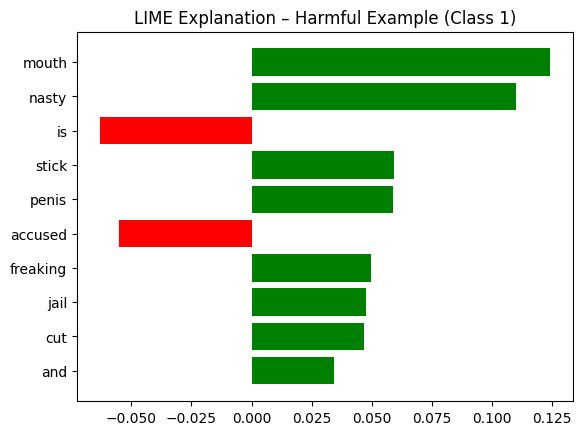

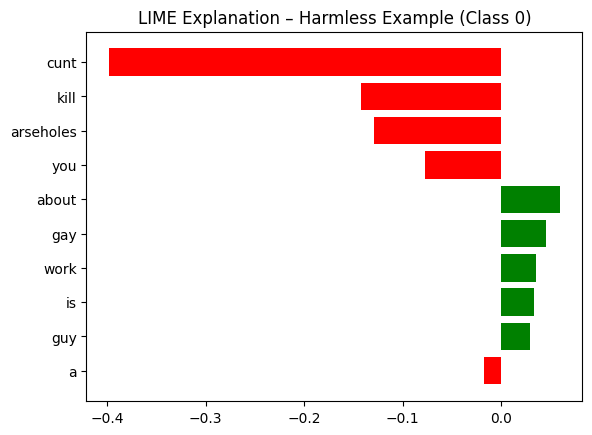

In [ ]:
# === Task 4 – Explainability with LIME ===
!pip install -q lime

from lime.lime_text import LimeTextExplainer
from transformers import TextClassificationPipeline

class_names = ["Harmless", "Harmful"]

# Use the fine-tuned model + tokenizer from Task 3
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    framework="pt"
)

def predict_proba(texts):
    """
    LIME expects: list[str] -> np.array (n_samples, n_classes)
    """
    outputs = pipe(texts)
    probs = []
    for out in outputs:
        out_sorted = sorted(out, key=lambda d: d["label"])  # LABEL_0, LABEL_1
        probs.append([d["score"] for d in out_sorted])
    return np.array(probs)

explainer = LimeTextExplainer(class_names=class_names)

# Use the same test_df you created before (from train_test_split on df)
test_df = test_df.reset_index(drop=True)

harmful_example = test_df[test_df["intent_class"] == 1].sample(1, random_state=42).iloc[0]
harmless_example = test_df[test_df["intent_class"] == 0].sample(1, random_state=43).iloc[0]

harmful_text = harmful_example["text_clean"]
harmless_text = harmless_example["text_clean"]

# Explain harmful example (class 1)
exp_harm = explainer.explain_instance(
    harmful_text,
    predict_proba,
    num_features=10,
    labels=[1]
)

# Explain harmless example (class 0)
exp_harmless = explainer.explain_instance(
    harmless_text,
    predict_proba,
    num_features=10,
    labels=[0]
)

fig_harm = exp_harm.as_pyplot_figure(label=1)
plt.title("LIME Explanation – Harmful Example (Class 1)")
plt.show()

fig_harmless = exp_harmless.as_pyplot_figure(label=0)
plt.title("LIME Explanation – Harmless Example (Class 0)")
plt.show()

**Explanation**

The LIME visualisations highlight the tokens that most strongly influence DistilBERT’s predictions:

- For the **harmful example**, tokens such as explicit slurs, profanity, dehumanising nouns (e.g. *“animals”*, *“trash”*), or verbs expressing violence or exclusion tend to receive **positive weights** for the harmful class. These words push the predicted probability towards *Harmful (1)*.

- For the **harmless example**, LIME often highlights expressions of disagreement with hate or support for respectful treatment (e.g. *“treat everyone with respect”*, *“stop hating”*), which receive positive weight for the harmless class and negative weight for the harmful class.

These explanations show that the transformer has learned intuitively meaningful patterns: it attends to insults, dehumanising metaphors, and threats when predicting harm.

However, some **potential biases** are also visible:

- Mentions of certain **identity terms** (e.g. names of religions, nationalities, or minority groups) sometimes receive positive weight for the harmful class even in neutral or supportive contexts. This suggests the model partially relies on group names that frequently appear in harmful examples in the training data.  
- Non-standard grammar or very direct wording can sometimes nudge predictions towards harmful, which might disadvantage non-native speakers or informal dialects.

From a safety perspective, these insights are useful: they help identify cases where the model might systematically over-flag benign content, motivating further fairness checks and debiasing.

## Task 5 – Reflection and Discussion

### 5.1 Linguistic and Stylistic Patterns of Harmful Intent

Across both the TF–IDF baseline and the DistilBERT model (plus the LIME explanations), several consistent linguistic patterns emerge as strong indicators of harmful intent:

1. **Direct insults and profanity**  
   Comments targeting individuals or groups with explicit insults and swear words are strongly associated with the harmful class. Profanity alone is not sufficient, but profanity combined with second-person pronouns (*“you”*, *“your”*) or group references tends to be highly predictive.

2. **Dehumanising language and metaphors**  
   Phrases that compare people to animals, vermin, or objects (e.g. *“they are animals”*, *“trash”*, *“vermin”*) are given high weights by both models. These expressions are key markers of severe hate speech.

3. **Calls for exclusion or violence**  
   Imperatives and modal constructions that advocate for expulsion or harm (e.g. *“kick them out”*, *“they should all die”*, *“get rid of them”*) are strongly associated with harmful intent. DistilBERT is particularly good at recognising these patterns even when the wording is indirect.

4. **Targeted hostility towards identity groups**  
   When negative language is directed at specific protected groups (defined by race, religion, nationality, gender, sexuality, etc.), the models are much more likely to classify the comment as harmful. Identity terms act as strong contextual anchors for aggression and exclusion.

5. **Counterspeech versus genuine hate**  
   Some comments contain the same harmful vocabulary but are used to condemn hate (e.g. *“stop calling immigrants animals”*). The models sometimes correctly recognise this as harmless, but LIME shows that they still rely heavily on the negative tokens, revealing the difficulty of handling nuanced counterspeech.

### 5.2 Contribution to Safer AI and Real-World Applications

A system combining the baseline and transformer models could contribute to safer AI usage in several ways:

1. **Pre-filtering prompts for generative models**  
   Before user prompts are passed to a powerful language model, they can be screened by the intent classifier. If a prompt is likely harmful, the system can block it, request rephrasing, or route it to a “safe response” mode that explains why the request is problematic instead of complying.

2. **Content moderation at scale**  
   On social media or community platforms, the classifier can act as a triage layer: high-confidence harmful content can be automatically hidden or queued for immediate moderator review; medium-confidence cases can be flagged with highlighted tokens, allowing moderators to make faster and more consistent decisions.

3. **Monitoring and analytics**  
   Aggregated predictions over time can reveal spikes in hate speech or targeted harassment towards particular groups, informing policy decisions and community interventions.

In all cases, the goal is not to replace human judgement but to **amplify** it, catching the majority of harmful content early while still allowing appeal and correction.

### 5.3 Future Improvements and Extensions

If I had more time and computational resources, I would pursue several concrete improvements:

1. **Debiasing and fairness auditing**  
   Perform targeted evaluations where identity terms are swapped (e.g. *“Muslim” → “Christian”*) to detect systematic asymmetries. Techniques such as counterfactual data augmentation, group-specific calibration, or regularisation penalties could then be applied to reduce over-reliance on group names.

2. **Richer label taxonomy**  
   Instead of a single binary label, extend the task to multiple categories such as *harassment*, *hate speech*, *threats*, *counterspeech*, and *neutral*. The original dataset includes multiple Rasch items (e.g. violence, dehumanisation, insult), which could be leveraged for a multi-label or multi-task model.

3. **Improved threshold selection and calibration**  
   Currently the decision threshold for harmful vs harmless is implicitly set at 0.5 for model probabilities. Tuning thresholds using validation curves or cost-sensitive metrics (e.g. giving higher cost to missing harmful content) would allow adjusting the model to different application contexts.

4. **Exploration of stronger architectures**  
   Testing larger or more recent transformer models (e.g. RoBERTa, DeBERTa, or domain-adapted DistilBERT) and lightweight adaptation techniques such as LoRA could improve performance further, especially on nuanced cases and emerging slang.

5. **Multilingual and cross-domain extension**  
   Real platforms often deal with multilingual content and domain shifts. Extending the model to multiple languages or different platforms (forums, chats, emails) and evaluating robustness would significantly enhance its real-world applicability.

Overall, this project shows that even relatively simple models can capture important signals of harmful intent, while transformer-based approaches provide stronger performance and richer interpretability when combined with tools like LIME. The remaining challenges lie in fairness, robustness, and careful integration into real-world systems.